# Final Project - Transfer Learning - VGG16

Using a pretrained CNN model, retraining with own pictures


**model building**
- pretrained models for medical images: VGG16, Inception
- the pretrained model without the dense layers is used as base model
- new dense layers suitable to the task you want to solve are added 
    - 1 dense layer to connect to base layer
    - 1 dense output layer, depending on the number of classes
- the base model is not trained (those trained layers are frozen)


## INFO for this notebook
- base model: VGG16
 

# Import packages

In [1]:
import pandas as pd
import numpy as np

# deep learning 
import keras
from keras.models import Model, Sequential
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# others
import os

2023-03-05 10:22:16.182821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Get Data

In [2]:
# get classes from train image set
CLASSES = os.listdir('data/train')
CLASSES

['cataract', 'glaucoma', 'diabetes', 'normal']

In [3]:
# instanicate ImageGenerator
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Load Training Data

In [4]:
# load training data
train_data = image_gen.flow_from_directory(
    directory='data/train',
    class_mode='categorical',
    classes=CLASSES,
    batch_size=400,
    target_size=(224,224)
)

Found 400 images belonging to 4 classes.


In [5]:
# creat training set
xtrain, ytrain = next(train_data)
xtrain.shape, ytrain.shape

((400, 224, 224, 3), (400, 4))

## Load Test Data 

In [6]:
# preprocess test data 
test_data = image_gen.flow_from_directory(
    directory='data/test',
    class_mode='categorical',
    classes=CLASSES,
    target_size=(224,224)
)

Found 40 images belonging to 4 classes.


In [7]:
# create test set
xtest, ytest = next(test_data)
xtest.shape, ytest.shape

((32, 224, 224, 3), (32, 4))

# Build Model

In [8]:
# create base model
base_model = VGG16(
    weights='imagenet',
    include_top=False, # remove the top dense layers
    input_shape=(224,224,3),
    pooling='avg' # average pooling transforms 4d tensor to 2d feature matrix
)

2023-03-05 10:22:42.498569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# create model
K.clear_session()
model = Sequential()

In [11]:
# add base_model to model
model.add(base_model)

In [12]:
# add custom layer on top of base model 
# with same number of neurons as output form previous layer
model.add(Dense(512, activation='relu'))

In [13]:
# add dropout 
model.add(keras.layers.Dropout(rate=0.5))

In [14]:
# add output layer with number of neurons matching number of classes(4)
model.add(Dense(4, activation='softmax'))

In [15]:
# compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss=keras.losses.categorical_crossentropy,
    metrics=[keras.metrics.categorical_accuracy]
    )

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,979,396
Trainable params: 264,708
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
# early stopping
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

In [19]:
# train model
training = model.fit(
            xtrain,
            ytrain,
            epochs=100,
            batch_size=20,
            callbacks=[stop_early],
            validation_split=0.2
)

Epoch 1/100
16/16 [==============================] - 80s 5s/step - loss: 1.9499 - categorical_accuracy: 0.6094 - val_loss: 1.8132 - val_categorical_accuracy: 0.6000
Epoch 2/100
16/16 [==============================] - 89s 6s/step - loss: 1.4324 - categorical_accuracy: 0.6313 - val_loss: 1.2430 - val_categorical_accuracy: 0.6750
Epoch 3/100
16/16 [==============================] - 88s 6s/step - loss: 1.0916 - categorical_accuracy: 0.6625 - val_loss: 1.0153 - val_categorical_accuracy: 0.5750
Epoch 4/100
16/16 [==============================] - 89s 6s/step - loss: 0.8551 - categorical_accuracy: 0.7031 - val_loss: 1.0025 - val_categorical_accuracy: 0.6250
Epoch 5/100
16/16 [==============================] - 87s 5s/step - loss: 0.8228 - categorical_accuracy: 0.6750 - val_loss: 0.8466 - val_categorical_accuracy: 0.6875
Epoch 6/100
16/16 [==============================] - 88s 6s/step - loss: 0.5556 - categorical_accuracy: 0.7812 - val_loss: 0.8535 - val_categorical_accuracy: 0.6500
Epoch 7/10

## Evaluate Model

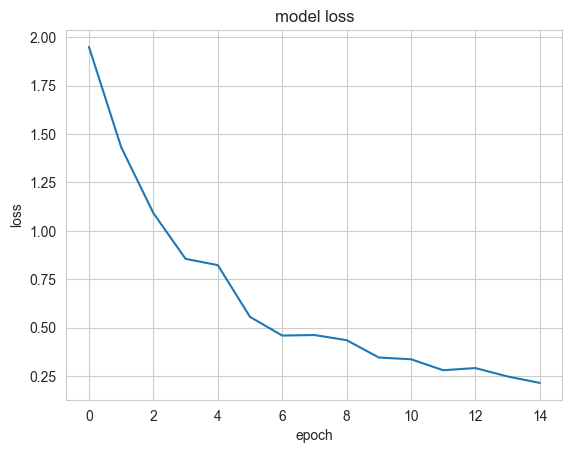

In [20]:
plt.plot(training.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [21]:
# predict test data
ypred = np.round(model.predict(xtest), 3)

1/1 [==============================] - 6s 6s/step


In [22]:
model.evaluate(xtrain, ytrain)

13/13 [==============================] - 84s 6s/step - loss: 0.3627 - categorical_accuracy: 0.8800


[0.36270496249198914, 0.8799999952316284]

In [23]:
model.evaluate(xtest, ytest)

1/1 [==============================] - 8s 8s/step - loss: 0.8140 - categorical_accuracy: 0.7812


[0.8139662742614746, 0.78125]

## Confusion Matrix

In [24]:
y_pred=np.argmax(ypred, axis=1)
y_test=np.argmax(ytest, axis=1)
cm = confusion_matrix(y_test, y_pred, normalize='true')
# cm = confusion_matrix(y_test, y_pred, normalize='pred')
# cm = confusion_matrix(y_test, y_pred, normalize='pred')
print(cm)

[[0.9        0.         0.1        0.        ]
 [0.         0.66666667 0.11111111 0.22222222]
 [0.         0.         0.83333333 0.16666667]
 [0.         0.         0.28571429 0.71428571]]


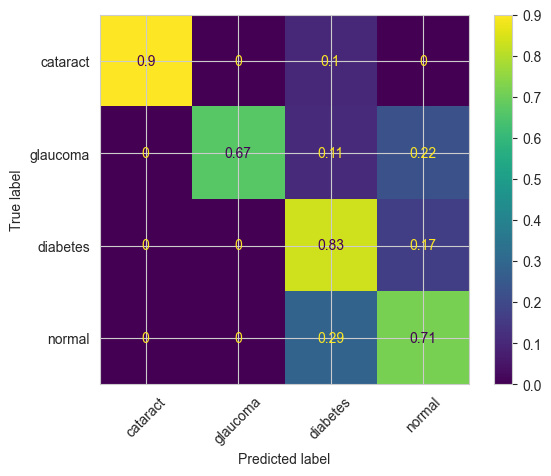

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)
plt.show()

## Save model

In [26]:

model.save("models/model_VGG16_local_0503_cleaning.h5")

In [14]:
model = load_model("models/model_VGG16_local_0503_cleaning.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14,979,396
Trainable params: 264,708
Non-trainable params: 14,714,688
_________________________________________________________________


## Test with pictures

In [27]:
def predict(image_path):
    """
    This function loads and image, processes the image and makes a prediction.
    """
    # load image
    img = image.load_img(path=image_path,target_size=(224,224))
    # process image
    img_array = image.img_to_array(img)
    img_batch = np.array([img_array])
    preprocessed_img = preprocess_input(img_batch)
    
    # make prediction
    probabilities = model.predict(preprocessed_img,verbose=0)
    # round preciction 
    probabilities = np.round(probabilities,3)[0]
    class_probabilities = dict(zip(CLASSES,probabilities))
    
    plt.bar(range(len(class_probabilities)), list(class_probabilities.values()), align='center')
    plt.xticks(range(len(class_probabilities)), list(class_probabilities.keys()))
        
    
    # return probailities and image
    return plt.show(), display(img) # with img.show()image will be pop up

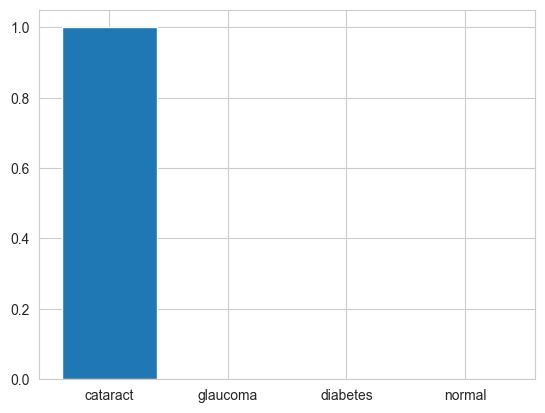

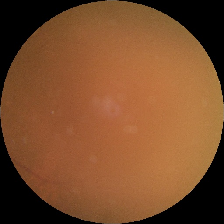

(None, None)

In [28]:
# show and preprocess image
predict('data/test/cataract/24_right.jpg')

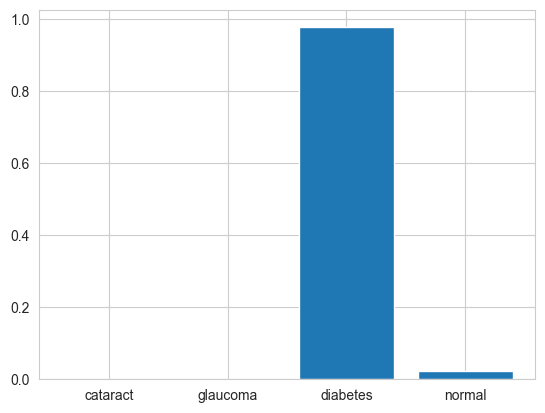

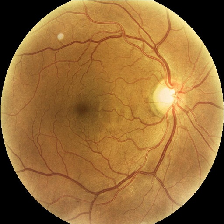

(None, None)

In [29]:
# show and preprocess image
predict('data/test/diabetes/19_right.jpg')

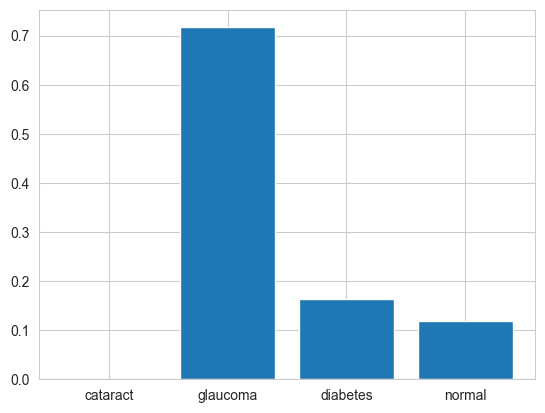

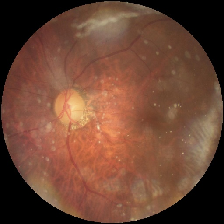

(None, None)

In [32]:
# show and preprocess image
predict('data/test/glaucoma/167_left.jpg')

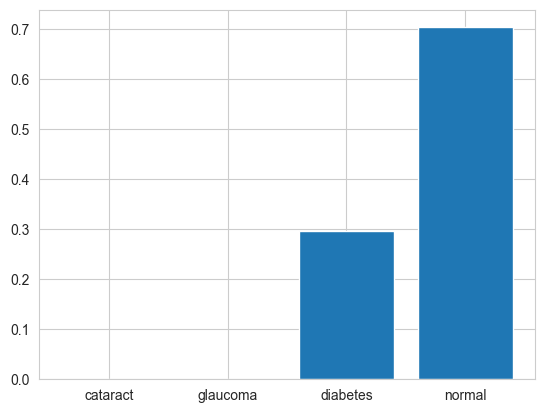

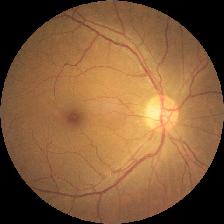

(None, None)

In [33]:
# show and preprocess image
predict('data/test/normal/1_right.jpg')

# Fine Tuning

In [34]:
# Unfreeze the base model
base_model.trainable = True

In [35]:
# compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
    loss=keras.losses.categorical_crossentropy,
    metrics=[keras.metrics.categorical_accuracy]
    )

In [37]:
# Train end-to-end. Be careful to stop before you overfit!
# train model
training = model.fit(
            xtrain,
            ytrain,
            epochs=100,
            batch_size=20,
            callbacks=[stop_early],
            validation_split=0.2
)

Epoch 1/100
16/16 [==============================] - 1509s 99s/step - loss: 0.3272 - categorical_accuracy: 0.8656 - val_loss: 0.9964 - val_categorical_accuracy: 0.6625
Epoch 2/100
16/16 [==============================] - 3191s 211s/step - loss: 0.1659 - categorical_accuracy: 0.9281 - val_loss: 1.1385 - val_categorical_accuracy: 0.6875
Epoch 3/100
16/16 [==============================] - 6118s 406s/step - loss: 0.1658 - categorical_accuracy: 0.9438 - val_loss: 0.9805 - val_categorical_accuracy: 0.6500
Epoch 4/100
16/16 [==============================] - 7102s 410s/step - loss: 0.0857 - categorical_accuracy: 0.9719 - val_loss: 1.2862 - val_categorical_accuracy: 0.6125
Epoch 5/100
16/16 [==============================] - 4107s 211s/step - loss: 0.0656 - categorical_accuracy: 0.9875 - val_loss: 1.2755 - val_categorical_accuracy: 0.6250
Epoch 6/100
16/16 [==============================] - 3022s 201s/step - loss: 0.0467 - categorical_accuracy: 0.9937 - val_loss: 1.3037 - val_categorical_accu

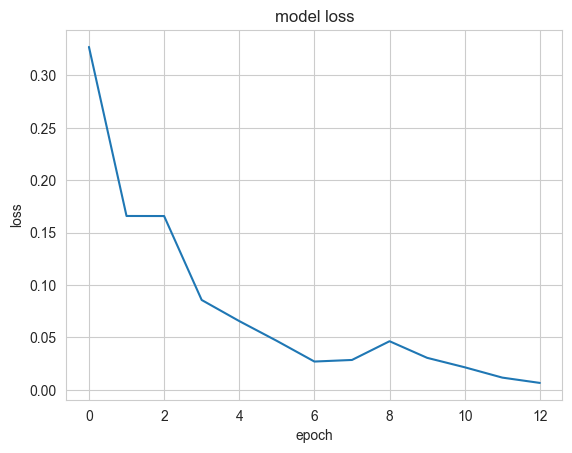

In [38]:
# plot loss
plt.plot(training.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [39]:
# evaluation for training set
model.evaluate(xtrain, ytrain)

13/13 [==============================] - 86s 7s/step - loss: 0.3156 - categorical_accuracy: 0.9350


[0.315552294254303, 0.9350000023841858]

In [40]:
model.evaluate(xtest, ytest)

1/1 [==============================] - 6s 6s/step - loss: 0.9569 - categorical_accuracy: 0.7500


[0.9568875432014465, 0.75]

In [41]:
# calculate predictions for test data
ypred = np.round(model.predict(xtest), 6)
ypred.shape

1/1 [==============================] - 6s 6s/step


(32, 4)

In [42]:
y_pred=np.argmax(ypred, axis=1)
y_test=np.argmax(ytest, axis=1)
cm = confusion_matrix(y_test, y_pred, normalize='true')
# cm = confusion_matrix(y_test, y_pred, normalize='pred')
# cm = confusion_matrix(y_test, y_pred, normalize='pred')
print(cm)

[[0.9        0.         0.1        0.        ]
 [0.         0.66666667 0.11111111 0.22222222]
 [0.         0.         0.66666667 0.33333333]
 [0.         0.         0.28571429 0.71428571]]


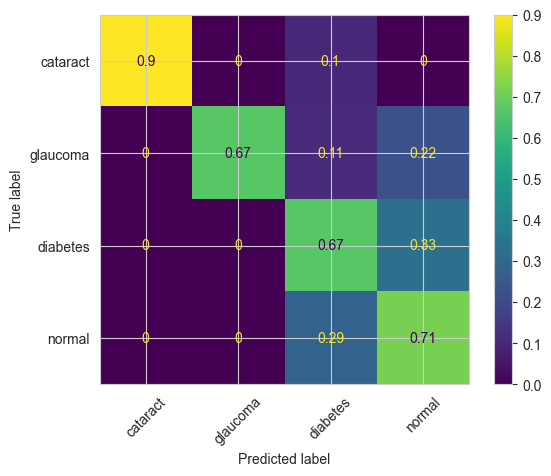

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)
plt.show()

In [ ]:
#model.save("models/model_VGG16_fine_tune.h5")